In [142]:
import os
import glob
from datetime import datetime
from datetime import timezone
import polars as pl
import polars.selectors as cs
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from utils.plot_data import plot_sensor_measurement
from lmu_meteo_api import interface
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

DATA_DIRECTORY = os.environ.get("DATA_DIRECTORY")
PICARRO_DATA_DIRECTORy = os.environ.get("PICARRO_DATA_DIRECTORY")

In [143]:
# raw measurement data
df_raw = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "download", "acropolis.parquet"))

# water corrected measurement data
df_dry = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "acropolis_dry.parquet"))

# slope and intercept data derived from calibrations
df_cal = pl.scan_parquet(os.path.join(DATA_DIRECTORY, "processed", "slope_intercept_acropolis.parquet")) \
    .with_columns((pl.col("creation_timestamp").dt.timestamp("ms") / 3.6e6).alias("timestamp")) #3.6e6 ms are in 1h
    
# 10m preprocessed picarro data
df_p_10m = pl.scan_parquet(os.path.join(DATA_DIRECTORY,"processed", "10m_cal_corr_picarro.parquet"))

calibration_accuracy_masks = []
correlation_analysis = []

In [144]:
start_date = datetime(2023, 12, 23, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 21, 23, 59, 59).replace(tzinfo=timezone.utc)



df_raw_agg_10m = df_raw.filter(pl.col("creation_timestamp").is_between(start_date, end_date))  \
        .sort("creation_timestamp") \
        .group_by_dynamic("creation_timestamp", every='10m', by= "system_name") \
        .agg(pl.all().exclude(["creation_timestamp","system_name"]).mean()) \
        .with_columns(pl.col("creation_timestamp").dt.date().alias("date")) \
        .join(df_cal.select("date","system_name","slope","intercept"), on = ["date","system_name"], how= "left") \
        .join(df_dry.select("creation_timestamp","system_name", "gmp343_dry"), on = ["creation_timestamp","system_name"], how= "left") \
        .join(df_p_10m.select("creation_timestamp", "CO2_corr"), on = ["creation_timestamp"], how= "left") \
        .with_columns([
                pl.col("system_name").str.extract(r'(\d+)',1).str.to_integer().alias("system_id"),
                ((pl.col("gmp343_dry")) * pl.col("slope") + pl.col("intercept")).alias("gmp343_corrected"),
                       ]) \
        .with_columns([
                (pl.col("CO2_corr") - pl.col("gmp343_corrected")).alias("diff"),
                       ]) \
        .collect()
        
# extraxt wind information from 3m pole at side-by-side (system 6)
df_sbs_wind = df_raw_agg_10m.filter(pl.col("system_id") == 6) \
        .select("creation_timestamp", "wxt532_speed_avg", "wxt532_direction_avg") \
        .rename({"wxt532_speed_avg": "wind_speed", "wxt532_direction_avg": "wind_direction"})
        
# join wind information into the dataset
df_raw_agg_10m = df_raw_agg_10m.join(df_sbs_wind, on = ["creation_timestamp"], how= "left")   
        
#aggregate to 1d level      
df_raw_agg_1d = df_raw_agg_10m.sort("creation_timestamp") \
        .group_by_dynamic("creation_timestamp", every='1d', by= "system_name") \
        .agg(pl.all().exclude(["creation_timestamp","system_name"]).mean())
        
        
df_raw_agg_10m = df_raw_agg_10m.with_columns(((pl.col("diff") < 2.0) & (pl.col("diff") > -2.0)).alias("calibration_accuracy"))
df_raw_agg_1d = df_raw_agg_1d.with_columns(((pl.col("diff") < 2.0) & (pl.col("diff") > -2.0)).alias("calibration_accuracy"))

## Functions

In [ ]:
def analyse_system(id, start_date, end_date, plotly = False, hide_plots = False):
    # add to df
    df_filtered = df_raw_agg_10m.filter(pl.col("creation_timestamp").is_between(start_date, end_date)) \
        .filter(pl.col("system_id").is_in(id)) \
        .with_columns((np.square(np.subtract(pl.col("CO2_corr"), pl.col("gmp343_corrected"))).mean()).alias("MSE_full_deployment")) \
        .with_columns(pl.col("MSE_full_deployment").sqrt().alias("RMSE_full_deployment"))
      
    if not hide_plots:
        sns.scatterplot(data=df_filtered,x='creation_timestamp',y='diff', hue="calibration_accuracy").set(title='PICARRO Dry CO2')
        plt.show()
        
        sns.scatterplot(data=df_filtered,x='creation_timestamp',y='CO2_corr', hue="calibration_accuracy", alpha = 0.5).set(title='PICARRO Dry CO2')
        plt.show()
        
        fig = px.scatter(df_filtered, x="creation_timestamp", y="slope", color="calibration_accuracy")
        fig.show()
    
    if plotly:
        fig = px.scatter(df_filtered, x="creation_timestamp", y="CO2_corr", color="calibration_accuracy")
        fig.show()
            
        fig = px.scatter(df_filtered, x="creation_timestamp", y="diff", color="calibration_accuracy")
        fig.show()

        fig = px.scatter(df_filtered, x="creation_timestamp", y="slope", color="calibration_accuracy")
        fig.show()

    
    df_1d_filtered = df_raw_agg_1d.filter(pl.col("creation_timestamp").is_between(start_date, end_date)) \
        .filter(pl.col("system_id") == id) \
        .select("date", "system_name", "calibration_accuracy", "diff")
        
    return df_filtered, df_1d_filtered

In [ ]:
def get_lmu_data(start_time="2024-01-01T00-00-00", end_time= "2024-01-02T00-00-00", station_id = 'MIM01'):

    parameters = [
        "air_temperature_2m",
        "air_temperature_30m",
        "relative_humidity_2m",
        "relative_humidity_30m",
        'wind_speed_30m', 
        'wind_from_direction_30m',
        "air_pressure"]

    # download from the API
    lmu_api = interface.meteo_data()
    data = lmu_api.get_meteo_data(parameters=parameters, 
                                station_id= station_id, 
                                start_time=start_time, 
                                end_time=end_time)
    
    df_lmu = pl.from_pandas(data, include_index = True) \
    .rename({"time": "creation_timestamp"}) \
    .with_columns(pl.col("creation_timestamp").dt.cast_time_unit("us").dt.replace_time_zone("UTC")) \
    .with_columns(pl.col("air_temperature_30m") -273.15) \
    .with_columns(pl.col("air_temperature_2m") -273.15)  \
    .with_columns(pl.col("air_pressure") / 100)  \
    .rename({"air_temperature_30m": "temperature", "relative_humidity_30m": "humidity", "air_pressure": "pressure"}) \
    .with_columns(
            pl.lit(f"lmu meteo").alias("system_name")
        ) \
    .sort("creation_timestamp") \
    .group_by_dynamic("creation_timestamp", every='10m', by= "system_name")  \
    .agg(pl.all().exclude(["creation_timestamp","system_name"]).mean()) \
        
    return df_lmu

In [ ]:
def plot_with_lmu_data(start_date, end_date, system_ids, df_lmu):
    
    df_10m, df_1d = analyse_system(system_ids, start_date, end_date, hide_plots=True)
           
    df_10m = df_10m.rename({"gmp343_temperature": "temperature", "sht45_humidity": "humidity", "bme280_pressure": "pressure"})
    
    df_plot = pl.concat([df_lmu, df_10m], how="diagonal")
    
    sns.lineplot(data=df_plot,x='creation_timestamp',y='pressure', hue="system_name").set(title='Pressure')
    plt.show()
    
    sns.lineplot(data=df_plot,x='creation_timestamp',y='humidity', hue="system_name").set(title='Humidity')
    plt.show()
    
    sns.lineplot(data=df_plot,x='creation_timestamp',y='temperature', hue="system_name").set(title='Temperature')
    plt.show()
    

    # fig = px.line(df_plot, x="creation_timestamp", y="enclosure_bme280_temperature", title = "Enclosure Temperature")
    # fig.show()

## System 1

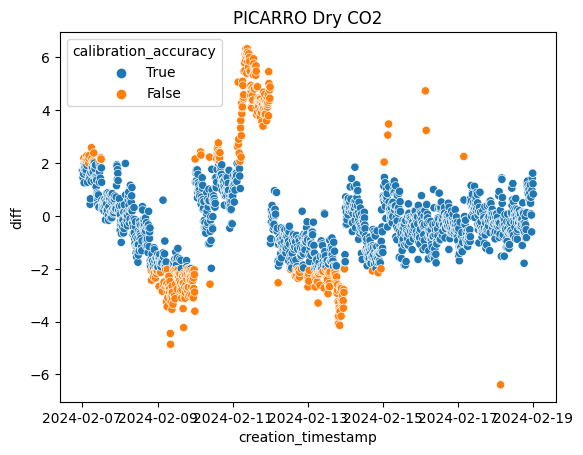

In [ ]:
start_date = datetime(2024, 2, 7, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 18, 23, 59, 59).replace(tzinfo=timezone.utc)

df_10m, df_1d = analyse_system(1, start_date, end_date)
calibration_accuracy_masks.append(df_1d)
correlation_analysis.append(df_10m)

## System 3

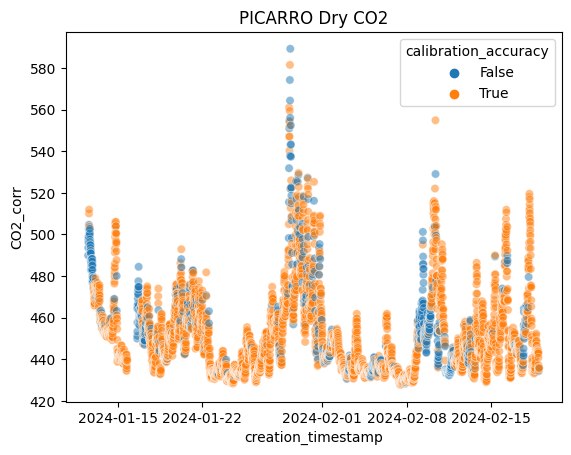

In [ ]:
start_date = datetime(2024, 1, 12, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 18, 23, 59, 59).replace(tzinfo=timezone.utc) # collected for deployment on 19.02.2024

df_10m, df_1d = analyse_system(3, start_date, end_date)
calibration_accuracy_masks.append(df_1d)
correlation_analysis.append(df_10m)

## System 4

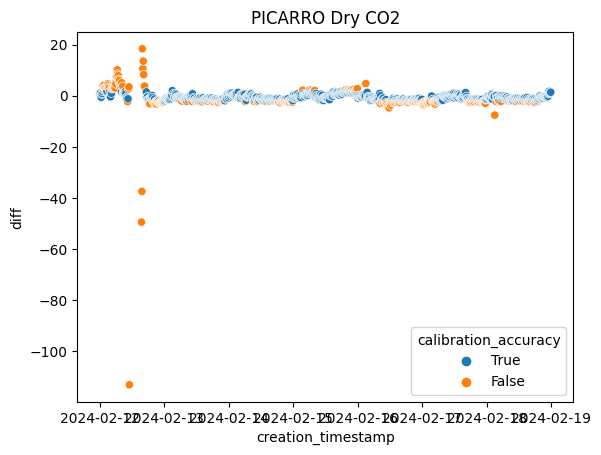

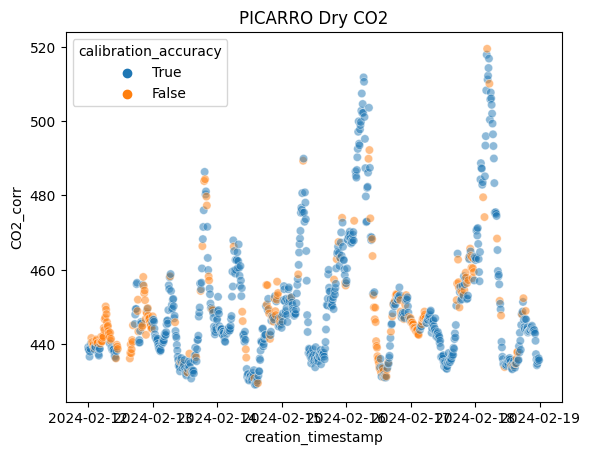

In [ ]:
start_date = datetime(2024, 2, 12, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 18, 23, 59, 59).replace(tzinfo=timezone.utc)

df_10m, df_1d = analyse_system(4, start_date, end_date)
calibration_accuracy_masks.append(df_1d)
correlation_analysis.append(df_10m)

## System 5

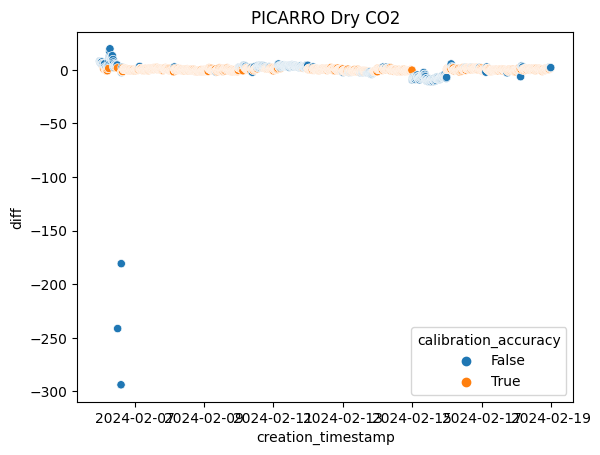

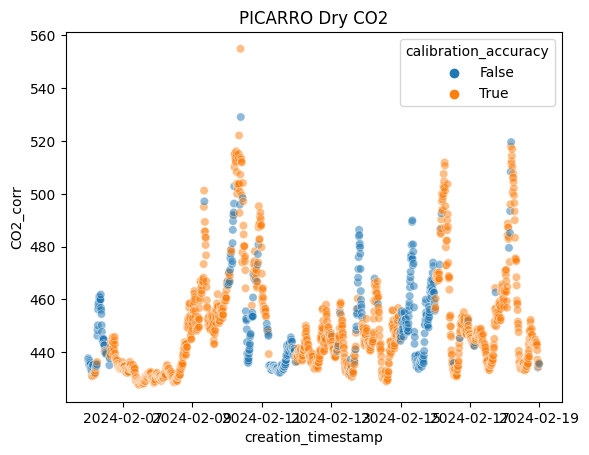

In [ ]:
start_date = datetime(2024, 2, 6, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 18, 23, 59, 59).replace(tzinfo=timezone.utc)

df_10m, df_1d = analyse_system(5, start_date, end_date)
calibration_accuracy_masks.append(df_1d)
correlation_analysis.append(df_10m)

## System 6

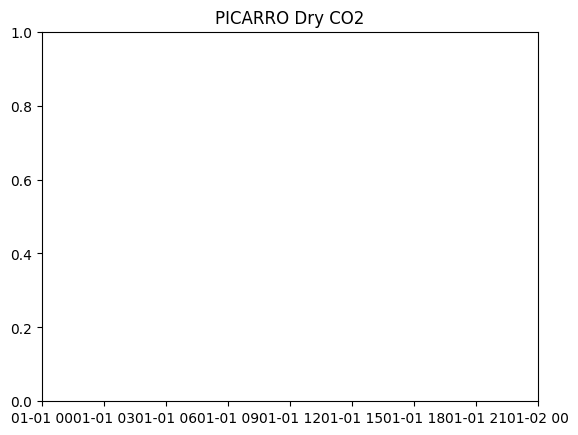

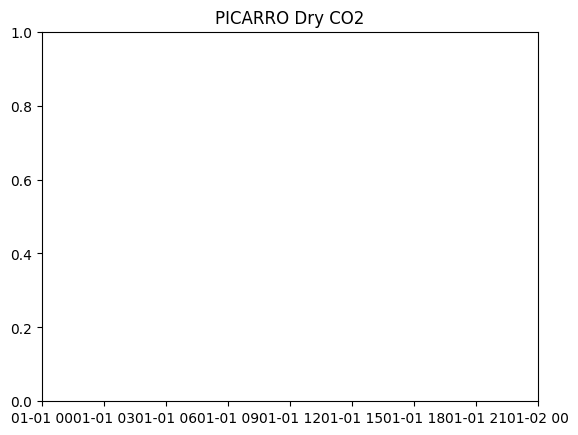

In [ ]:
start_date = datetime(2024, 2, 20, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 3, 6, 23, 59, 59).replace(tzinfo=timezone.utc) # maintenance on 19.02

df_10m, df_1d = analyse_system(6,start_date, end_date)
#calibration_accuracy_masks.append(df_1d)
#correlation_analysis.append(df_10m)

## System 8

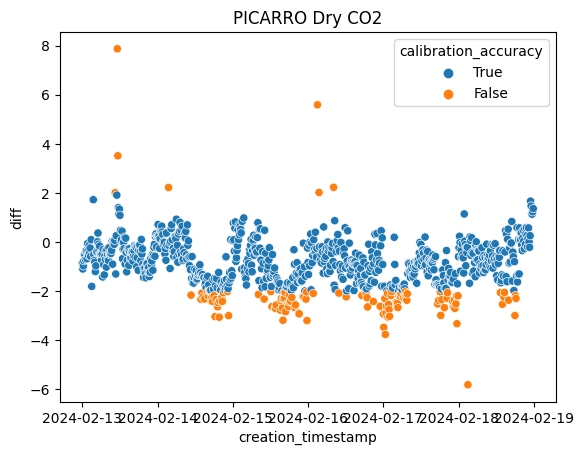

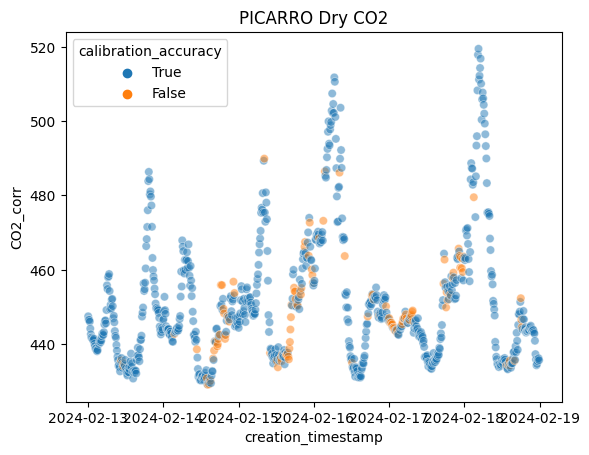

In [ ]:
start_date = datetime(2024, 2, 13, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 18, 23, 59, 59).replace(tzinfo=timezone.utc)

df_10m, df_1d = analyse_system(8, start_date, end_date)
calibration_accuracy_masks.append(df_1d)
correlation_analysis.append(df_10m)

## System 9

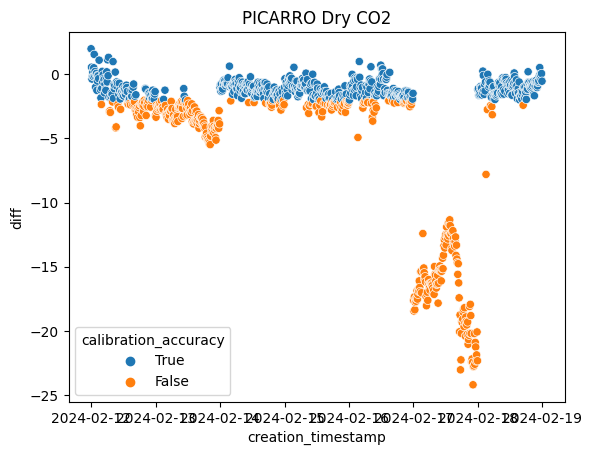

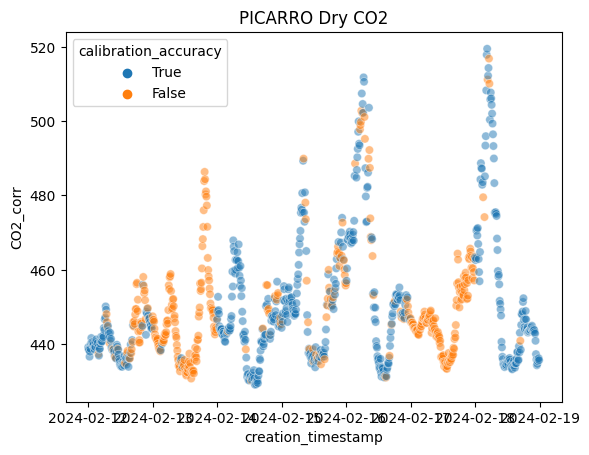

In [ ]:
start_date = datetime(2024, 2, 12, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 18, 23, 59, 59).replace(tzinfo=timezone.utc)

df_10m, df_1d = analyse_system(9, start_date, end_date)
calibration_accuracy_masks.append(df_1d)
correlation_analysis.append(df_10m)

## System 10

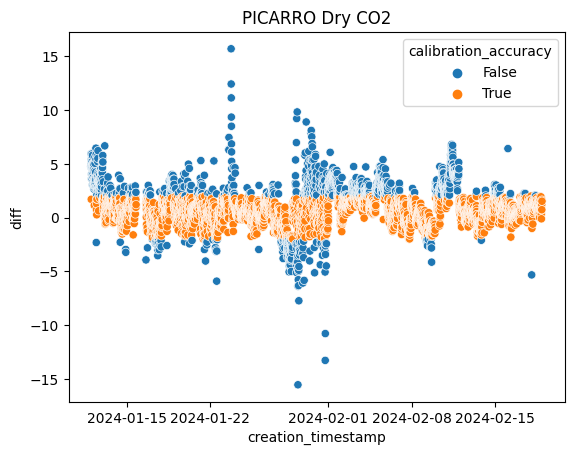

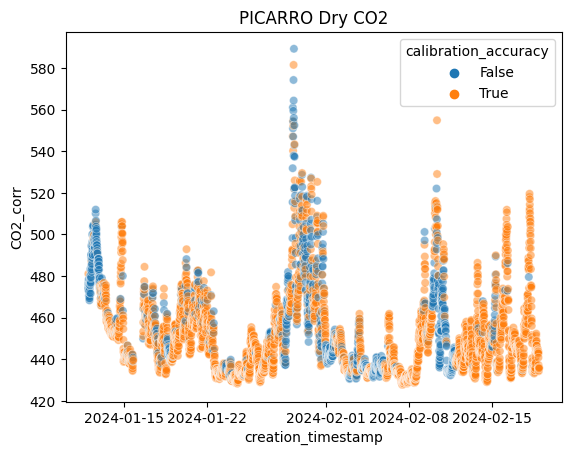

In [ ]:
start_date = datetime(2024, 1, 12, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 18, 23, 59, 59).replace(tzinfo=timezone.utc)

df_10m, df_1d = analyse_system(10, start_date, end_date)
calibration_accuracy_masks.append(df_1d)
correlation_analysis.append(df_10m)

## System 11

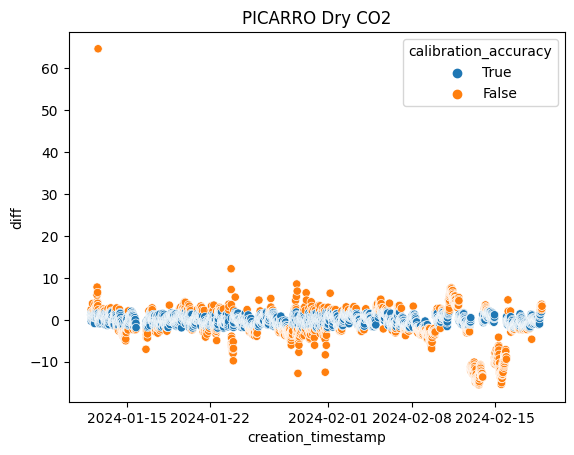

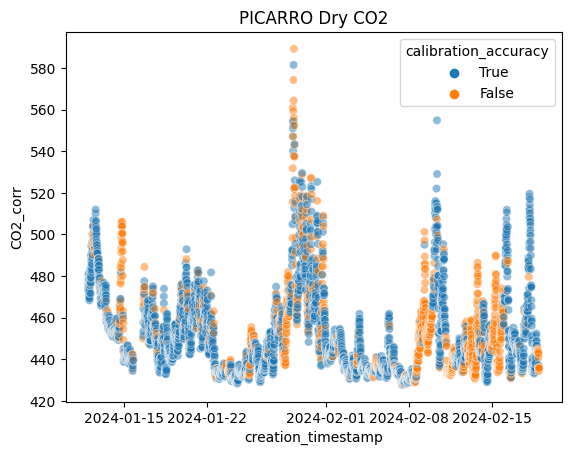

In [ ]:
start_date = datetime(2024, 1, 12, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 18, 23, 59, 59).replace(tzinfo=timezone.utc)

df_10m, df_1d = analyse_system(11, start_date, end_date)
calibration_accuracy_masks.append(df_1d)
correlation_analysis.append(df_10m)

# System 12

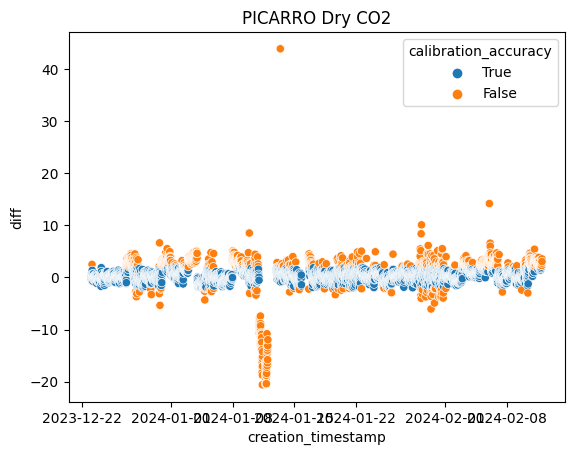

In [ ]:
id = 12

start_date = datetime(2023, 12, 23, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 11, 23, 59, 59).replace(tzinfo=timezone.utc) # in the field

df_10m, df_1d = analyse_system(12, start_date, end_date)
calibration_accuracy_masks.append(df_1d)
correlation_analysis.append(df_10m)

## System 13

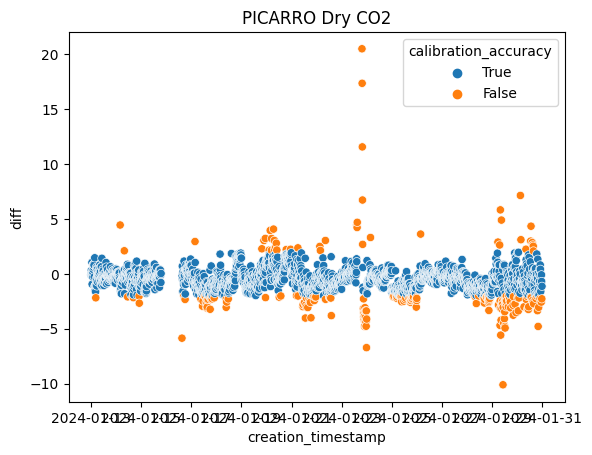

In [ ]:
start_date = datetime(2024, 1, 13, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 1, 30, 23, 59, 59).replace(tzinfo=timezone.utc) # collected for deployment on 19.02.2024

df_10m, df_1d = analyse_system(13, start_date, end_date)
calibration_accuracy_masks.append(df_1d)
correlation_analysis.append(df_10m)

## System 16

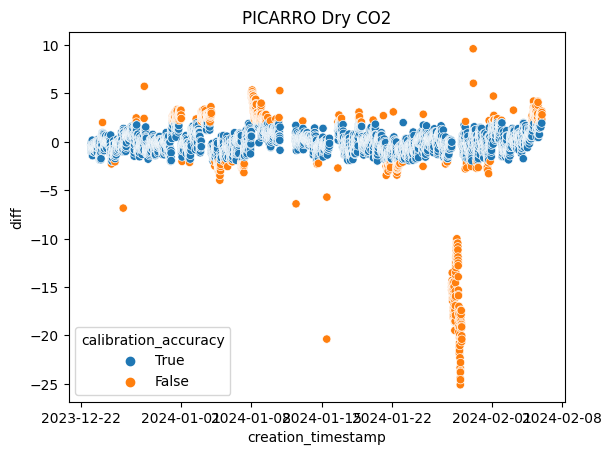

In [ ]:
start_date = datetime(2023, 12, 23, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 5, 23, 59, 59).replace(tzinfo=timezone.utc) # in the field

df_10m, df_1d = analyse_system(16, start_date, end_date)
calibration_accuracy_masks.append(df_1d)
correlation_analysis.append(df_10m)

## System 18

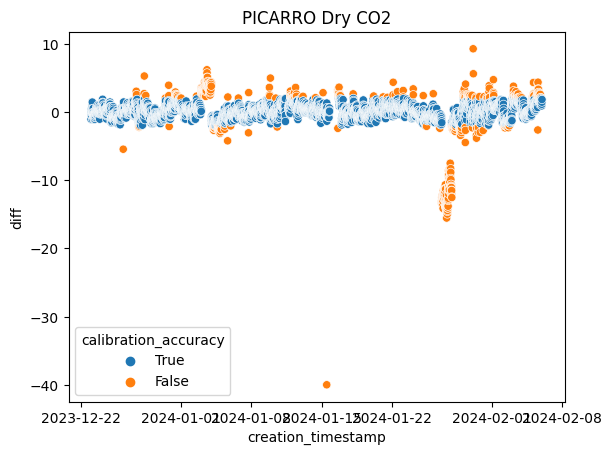

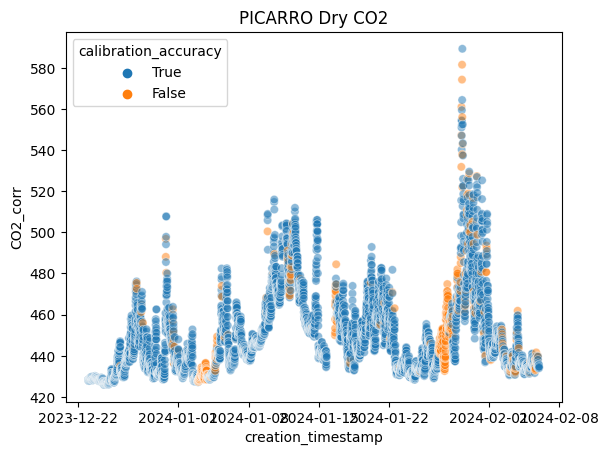

In [ ]:
id = 18

start_date = datetime(2023, 12, 23, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 5, 23, 59, 59).replace(tzinfo=timezone.utc) # in the field

df_10m, df_1d = analyse_system(18, start_date, end_date)
calibration_accuracy_masks.append(df_1d)
correlation_analysis.append(df_10m)

## System 20

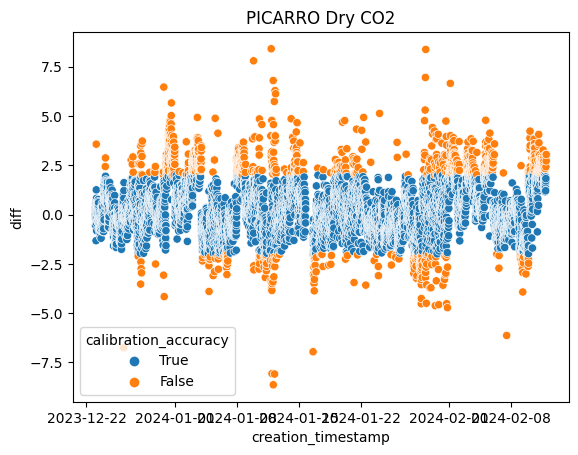

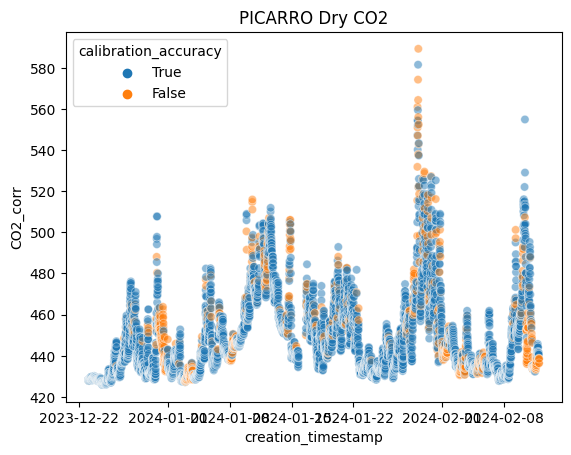

In [ ]:
start_date = datetime(2023, 12, 23, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 11, 23, 59, 59).replace(tzinfo=timezone.utc) # in the field

df_10m, df_1d = analyse_system(20, start_date, end_date)
calibration_accuracy_masks.append(df_1d)
correlation_analysis.append(df_10m)

# Cluster Analysis

In [ ]:
df_cluster_analysis = pl.concat(calibration_accuracy_masks, how="diagonal")

fig = px.scatter(df_cluster_analysis, x="date", y="system_name", title = "Cluster Analysis", color="calibration_accuracy")
fig.show()

fig = px.scatter(df_cluster_analysis, x="date", y="diff", title = "Cluster Analysis", color="system_name")
fig.show()

In [ ]:
df_correlation_analysis = pl.concat(correlation_analysis, how="diagonal")

corr = df_correlation_analysis.fill_null(strategy = "forward") \
    .fill_null(strategy = "backward") \
    .drop("system_name","date","revision","receipt_timestamp","system_id") \
    .drop(cs.starts_with("wxt532_")).drop(cs.starts_with("cal_")).drop(cs.starts_with("raspi_")).drop(cs.starts_with("ups_")) \
    .to_pandas() \
    .corr()


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))

sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True,
    xticklabels=1, yticklabels=1,
    )

plt.show()

Let's analyse the dates 31.12, 03.01, 10.02, 11.02

Maintenance dates:

12.01 Integration of new calibration bottles 3,6,11,13 + check on already installed bottles

05.02 New inlets in the afternoon

13.02 (Upgrade inlets 10:30 - 12:00 local time)

## Good Day

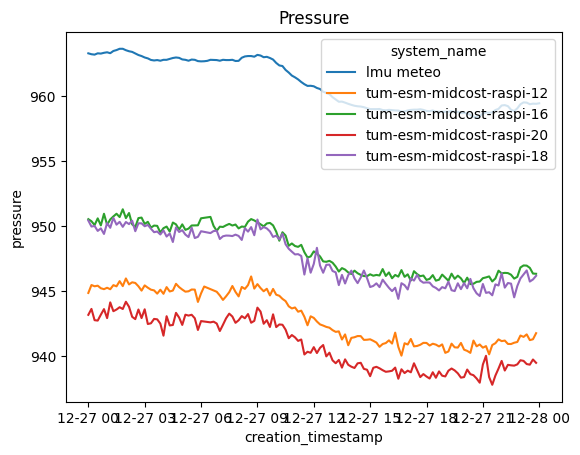

In [ ]:
start_date = datetime(2023, 12, 27, 00, 00, 00).replace(tzinfo=timezone.utc)
end_date = datetime(2023, 12, 27, 23, 59, 59).replace(tzinfo=timezone.utc)

system_ids = [12,16,18,20]

df_lmu = get_lmu_data(start_time="2023-12-27T00-00-00", end_time= "2023-12-27T23-59-59")
plot_with_lmu_data(start_date, end_date, system_ids, df_lmu)

## Bad Days

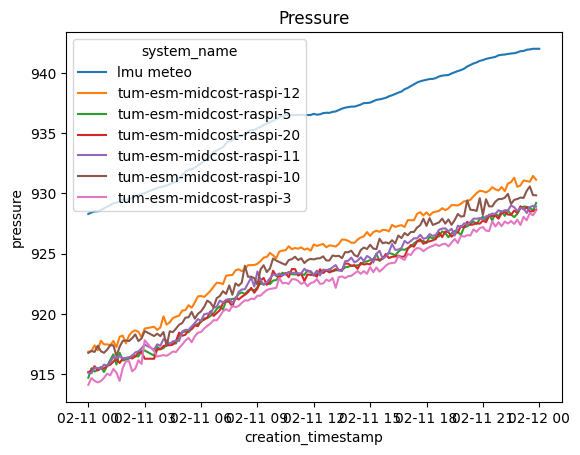

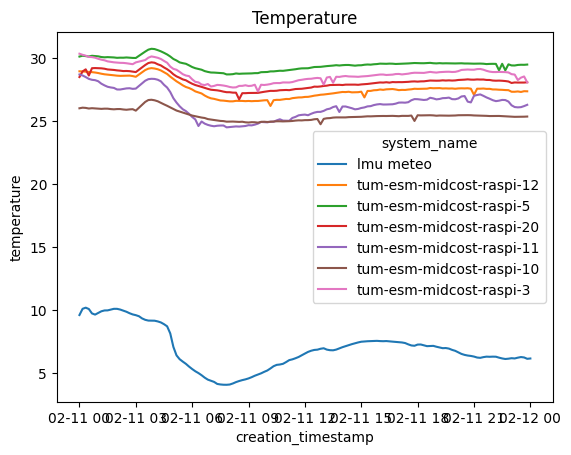

In [ ]:
start_date = datetime(2024, 2, 11, 00, 00, 00).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 11, 23, 59, 59).replace(tzinfo=timezone.utc)

system_ids = [3,5,10,11,12,20]

df_lmu = get_lmu_data(start_time="2024-02-11T00-00-00", end_time= "2024-02-11T23-59-59")
plot_with_lmu_data(start_date, end_date, system_ids, df_lmu)

## 11.02

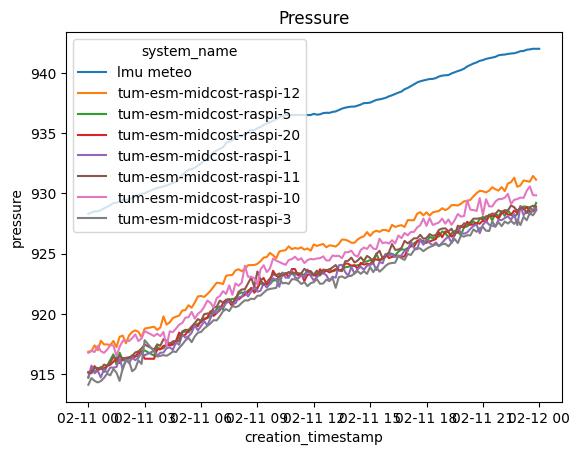

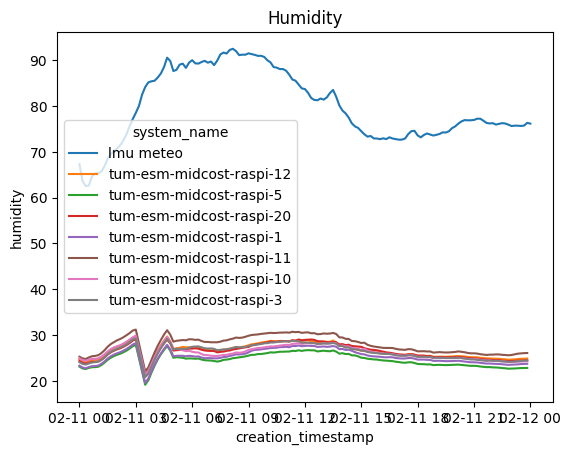

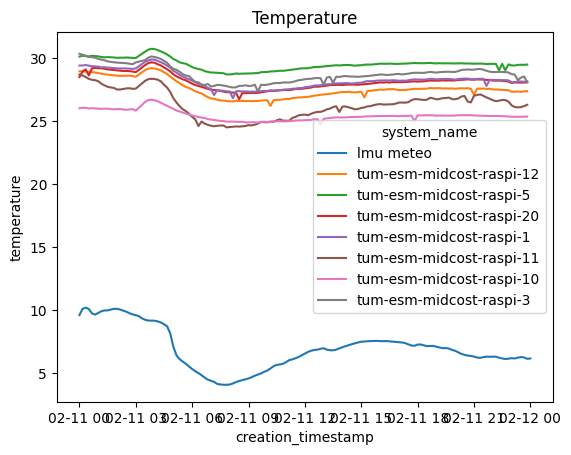

In [ ]:
start_date = datetime(2024, 2, 11, 00, 00, 00).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 11, 23, 59, 59).replace(tzinfo=timezone.utc)

system_ids = [1,3,5,10,11,12,20]

df_lmu = get_lmu_data(start_time="2024-02-11T00-00-00", end_time= "2024-02-11T23-59-59")
plot_with_lmu_data(start_date, end_date, system_ids, df_lmu)


## 10.02

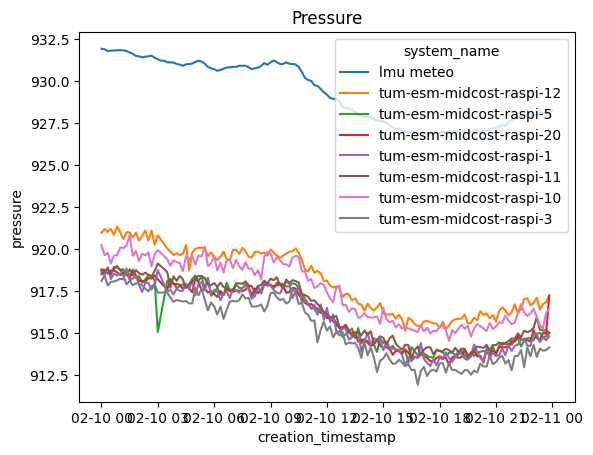

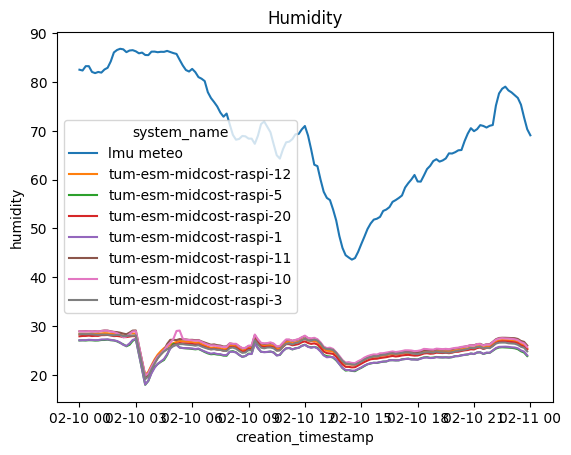

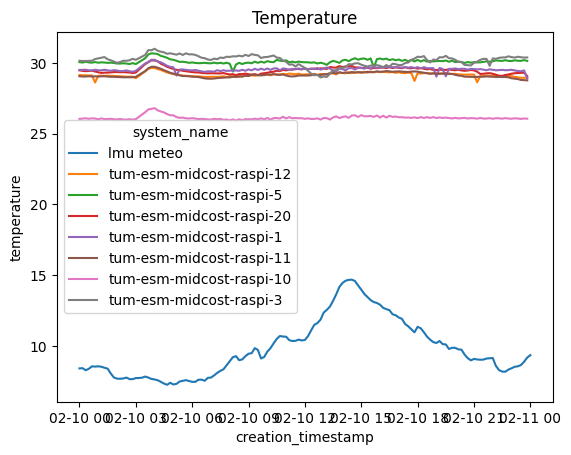

In [ ]:
start_date = datetime(2024, 2, 10, 00, 00, 00).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 2, 10, 23, 59, 59).replace(tzinfo=timezone.utc)

system_ids = [1,3,5,10,11,12,20]

df_lmu = get_lmu_data(start_time="2024-02-10T00-00-00", end_time= "2024-02-10T23-59-59")
plot_with_lmu_data(start_date, end_date, system_ids, df_lmu)

## 03.01

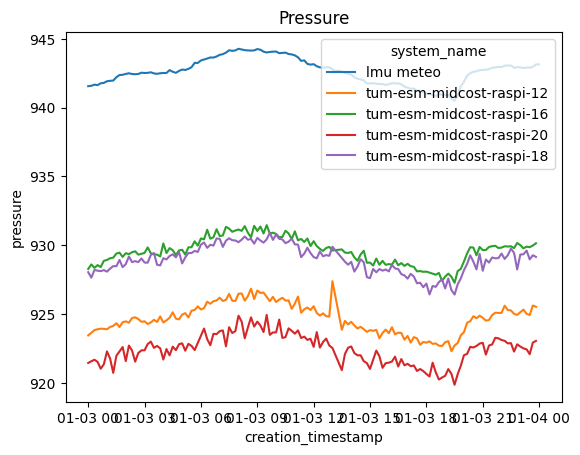

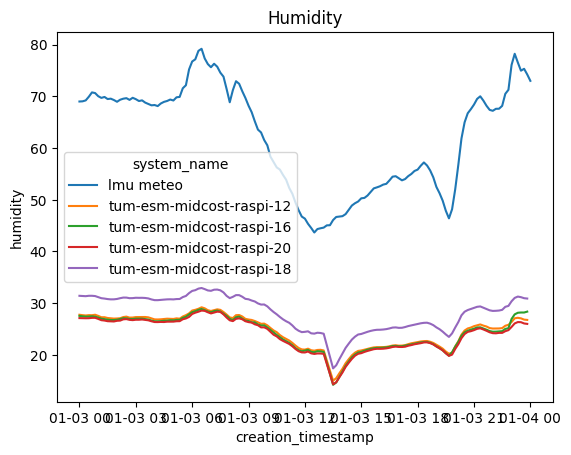

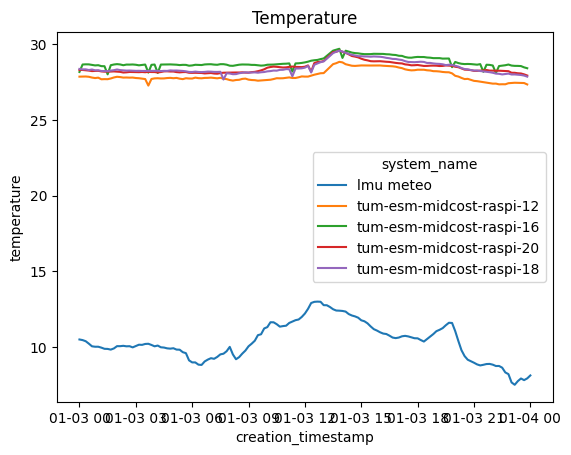

In [ ]:
start_date = datetime(2024, 1, 3, 0, 0, 0).replace(tzinfo=timezone.utc)
end_date = datetime(2024, 1, 3, 23, 59, 59).replace(tzinfo=timezone.utc)

system_ids = [12,16,18,20]

df_lmu = get_lmu_data(start_time="2024-01-03T00-00-00", end_time= "2024-01-03T23-59-59")
plot_with_lmu_data(start_date, end_date, system_ids, df_lmu)

# Tests